In [243]:
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/ && echo 'Done'

chmod: cannot access 'kaggle.json': No such file or directory


In [244]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [245]:
! kaggle datasets download abhi8923shriv/sentiment-analysis-dataset
! ls

sentiment-analysis-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_data			testdata.manual.2009.06.14.csv
sentiment-analysis-dataset.zip	train.csv
test.csv			training.1600000.processed.noemoticon.csv


In [246]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [247]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 2
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [248]:
!unzip "sentiment-analysis-dataset.zip" -d ""

Archive:  sentiment-analysis-dataset.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test.csv                
  inflating: testdata.manual.2009.06.14.csv  
  inflating: train.csv               
  inflating: training.1600000.processed.noemoticon.csv  


In [249]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS, low_memory=False)
df = df.iloc[1:]

In [250]:
print("Dataset size:", len(df))

Dataset size: 1048572


In [251]:
df['target'] = df['target'].astype(int)
# df_train.target.unique()

In [252]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [253]:
%%time
# df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


Text(0.5, 1.0, 'Dataset labels distribuition')

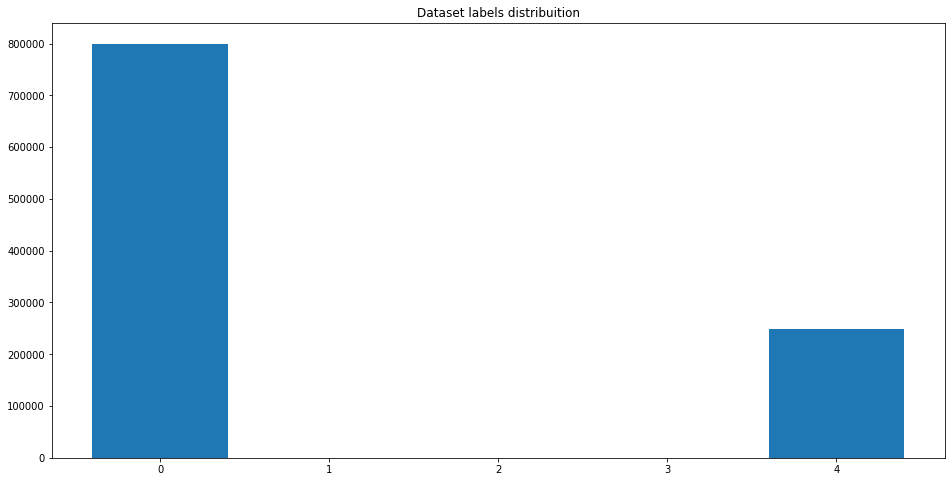

In [254]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [255]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [256]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [257]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 29.8 s, sys: 121 ms, total: 29.9 s
Wall time: 29.9 s


In [288]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 838857
TEST size: 209715


In [259]:
# %%time
# documents = [_text.split() for _text in df_train.text] 

In [260]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [261]:
# w2v_model.build_vocab(documents)

In [262]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 210655
CPU times: user 9.38 s, sys: 52.3 ms, total: 9.43 s
Wall time: 9.42 s


In [281]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 15.4 s, sys: 750 ms, total: 16.1 s
Wall time: 15.8 s


In [264]:
labels = df_train.target.unique().tolist()
print(labels)
labels

[0, 4]


[0, 4]

In [290]:
encoder = LabelEncoder()
encoder.fit(df_test.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

# df_train['target'] = encoder.transform(df_train.target.tolist())
# df_test['target'] = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (838857, 1)
y_test (209715, 1)


In [291]:
print("x_train", df_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", df_test.shape)
print("y_test", y_test.shape)

x_train (838857, 6)
y_train (838857, 1)

x_test (209715, 6)
y_test (209715, 1)


In [292]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(210655, 300)


In [293]:
df_train.target.unique()

array([0, 4])

In [294]:
df_test.head()

,target,ids,date,flag,user,text
915964,4,1753216957,Sun May 10 00:36:47 PDT 2009,NO_QUERY,Brenna_Bee,came bak dancing neewwww cd haha im dancing
357841,0,2044976566,Fri Jun 05 10:03:46 PDT 2009,NO_QUERY,urbanperspectiv,post office n runnin around geesh gotta put dr...
613199,0,2225278282,Thu Jun 18 10:31:35 PDT 2009,NO_QUERY,canu_diggit,ooooooh song hope knows otherwise going pissed
775465,0,2321851929,Wed Jun 24 21:39:55 PDT 2009,NO_QUERY,jjbabyMEOWZER,wish iwasnt im think n amp around making confu...
825096,4,1556402846,Sat Apr 18 22:42:10 PDT 2009,NO_QUERY,djphrenzy,twitter according thalia


In [295]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [296]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2021-06-06 12:54:55,554 : WARNING : Layer lstm_10 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          63196500  
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 63,357,001
Trainable params: 160,501
Non-trainable params: 63,196,500
_________________________________________________________________


In [273]:
print(tf.__version__)

2.5.0


In [297]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          63196500  
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 63,357,001
Trainable params: 160,501
Non-trainable params: 63,196,500
_________________________________________________________________


In [298]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [299]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [301]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=25,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/25
738/738 [==============================] - 6s 8ms/step - loss: 0.5479 - accuracy: 0.7628 - val_loss: 0.5479 - val_accuracy: 0.7627
Epoch 2/25
738/738 [==============================] - 6s 8ms/step - loss: 0.5479 - accuracy: 0.7628 - val_loss: 0.5480 - val_accuracy: 0.7627
Epoch 3/25
738/738 [==============================] - 6s 8ms/step - loss: 0.5479 - accuracy: 0.7628 - val_loss: 0.5479 - val_accuracy: 0.7627
Epoch 4/25
738/738 [==============================] - 6s 8ms/step - loss: 0.5479 - accuracy: 0.7628 - val_loss: 0.5479 - val_accuracy: 0.7627
Epoch 5/25
738/738 [==============================] - 6s 8ms/step - loss: 0.5479 - accuracy: 0.7628 - val_loss: 0.5479 - val_accuracy: 0.7627
Epoch 6/25
738/738 [==============================] - 6s 8ms/step - loss: 0.5479 - accuracy: 0.7628 - val_loss: 0.5479 - val_accuracy: 0.7627
CPU times: user 47.9 s, sys: 6.45 s, total: 54.3 s
Wall time: 36.5 s


In [302]:
%%time
score = model.evaluate(df_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

ValueError: ignored

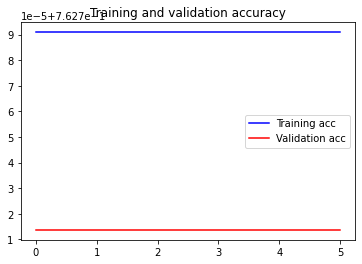

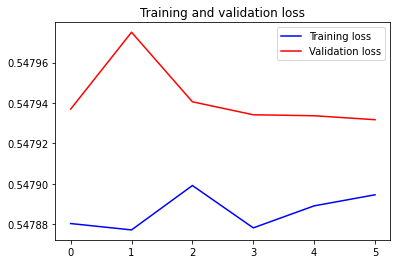

In [303]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [306]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    print(x_test)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [307]:
predict("I love you", include_neutral=True)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0 22]]


{'elapsed_time': 0.10013771057128906,
 'label': 'NEGATIVE',
 'score': 0.01917937956750393}

In [ ]:
model.save("my_h5_model.h5")

In [ ]:
import tensorflow as tf
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!ls /content/gdrive/MyDrive

In [ ]:

import os
save_path = os.path.join("/content/gdrive/MyDrive/coba/1")

In [ ]:
tf.keras.models.save_model(model, save_path)

In [ ]:
!ls /content/gdrive/MyDrive


In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)